# Forecasting taxi orders.

The company "Chetenko Taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak loads, it is necessary to forecast the number of taxi orders for the next hour. We will build a model for such a prediction. 

The value of the RMSE metric on the test sample should not be more than 48. 

We need to: 
1. Load the data and resample it by one hour; 
2. Analyze the data; 
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data; 
4. Check the data on the test sample and make conclusions.

## Contents:
1. Reviewing and preprocessing of the data.
2. EDA.
3. Training models.
4. Testing models.
5. Overall conclusion.

## 1. Reviewing and preprocessing of the data.

In [1]:
! pip install catboost
! pip install lightgbm
! pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In [3]:
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

In [4]:
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

Let's load the data.

In [5]:
url = 'https://code.s3.yandex.net/datasets/taxi.csv'
data = pd.read_csv(url, index_col=[0], parse_dates=[0])

Let's take a look at the data.

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


There are no missing values in the dataset.

In [8]:
data.index.is_monotonic

True

We can see that the data is organized.

We will perform hourly resampling, as well as additional monthly and weekly resampling.

In [9]:
data = data.resample('1H').sum()
monthly_stat = data.resample('1M').sum()
weekly_stat = data.resample('1W').sum()
hourly_stat = data.resample('1H').sum()

## 2. EDA.

Let's take a look at the order statistics broken down by month.

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

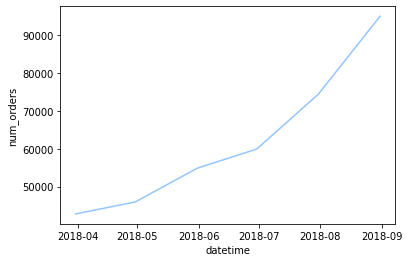

In [10]:
sns.lineplot(x=monthly_stat.index,
             y=monthly_stat['num_orders'])

We can see that the business is not standing still, but is developing. In June we see a decrease in the growth rate of orders.

Let's take a look at the order statistics broken down by week.

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

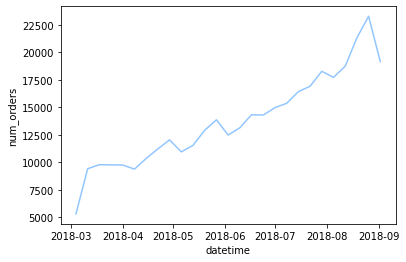

In [11]:
sns.lineplot(x=weekly_stat.index,
             y=weekly_stat['num_orders'])

We can also see an increase in the number of orders on a weekly basis, but from week to week there is an uneven growth with a decrease in the number of orders relative to the previous week.

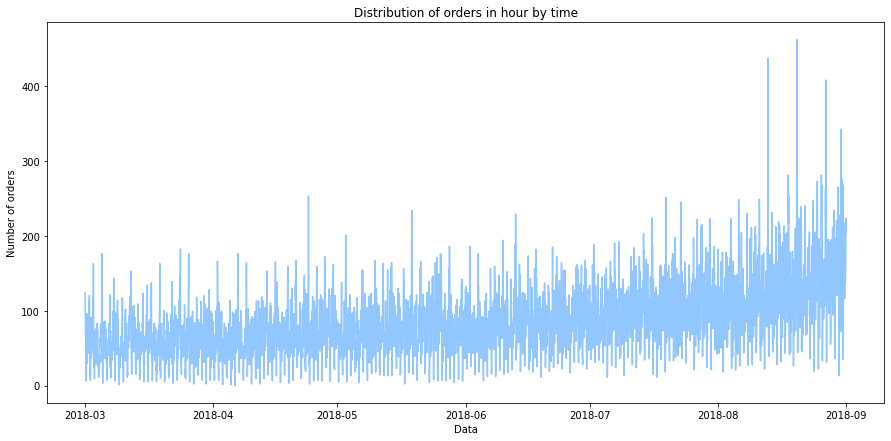

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(data)
plt.title('Distribution of orders in hour by time')
plt.xlabel('Data')
plt.ylabel('Number of orders')
plt.show()

Let's take a closer look at the daily changes in orders.

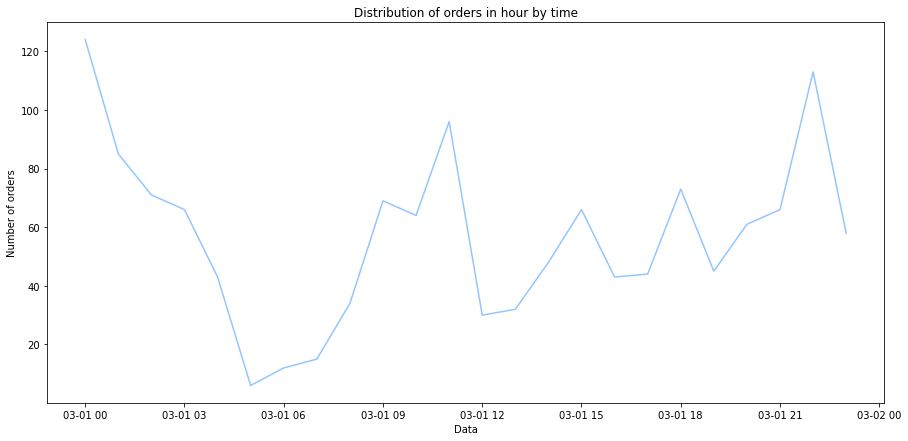

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(data['2018-03-01':'2018-03-01'])
plt.title('Distribution of orders in hour by time')
plt.xlabel('Data')
plt.ylabel('Number of orders')
plt.show()

We see the main peak of orders around 21-22. Second place peak at 10-11. We also see two peaks at 15 and 18. The number of orders increases by the end of the day. The distribution is logical and consistent with life.

Moving average.

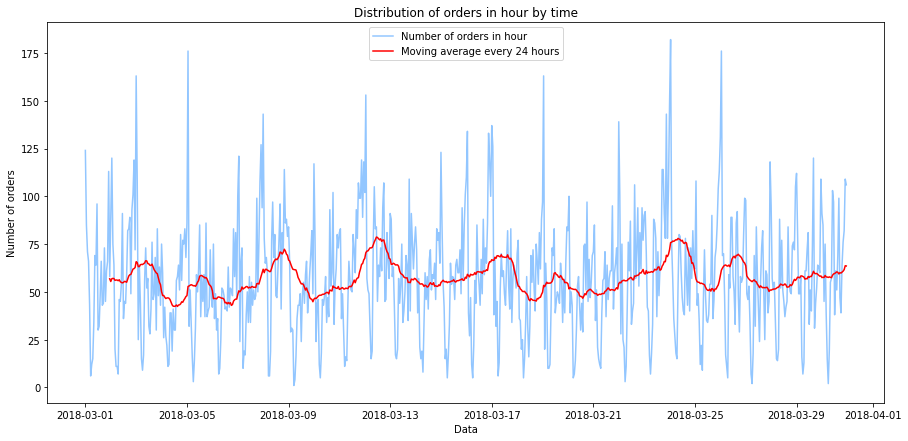

In [14]:
plt.figure(figsize=(15, 7))

plt.plot(data['2018-03-01':'2018-03-30'])

plt.plot(data['2018-03-01':'2018-03-30'].rolling(24).mean(), 
         color='red')

plt.title('Distribution of orders in hour by time')
plt.legend(['Number of orders in hour', 
            'Moving average every 24 hours'])
plt.xlabel('Data')
plt.ylabel('Number of orders')
plt.show()

Let's take a closer look at the trends and seasonality.

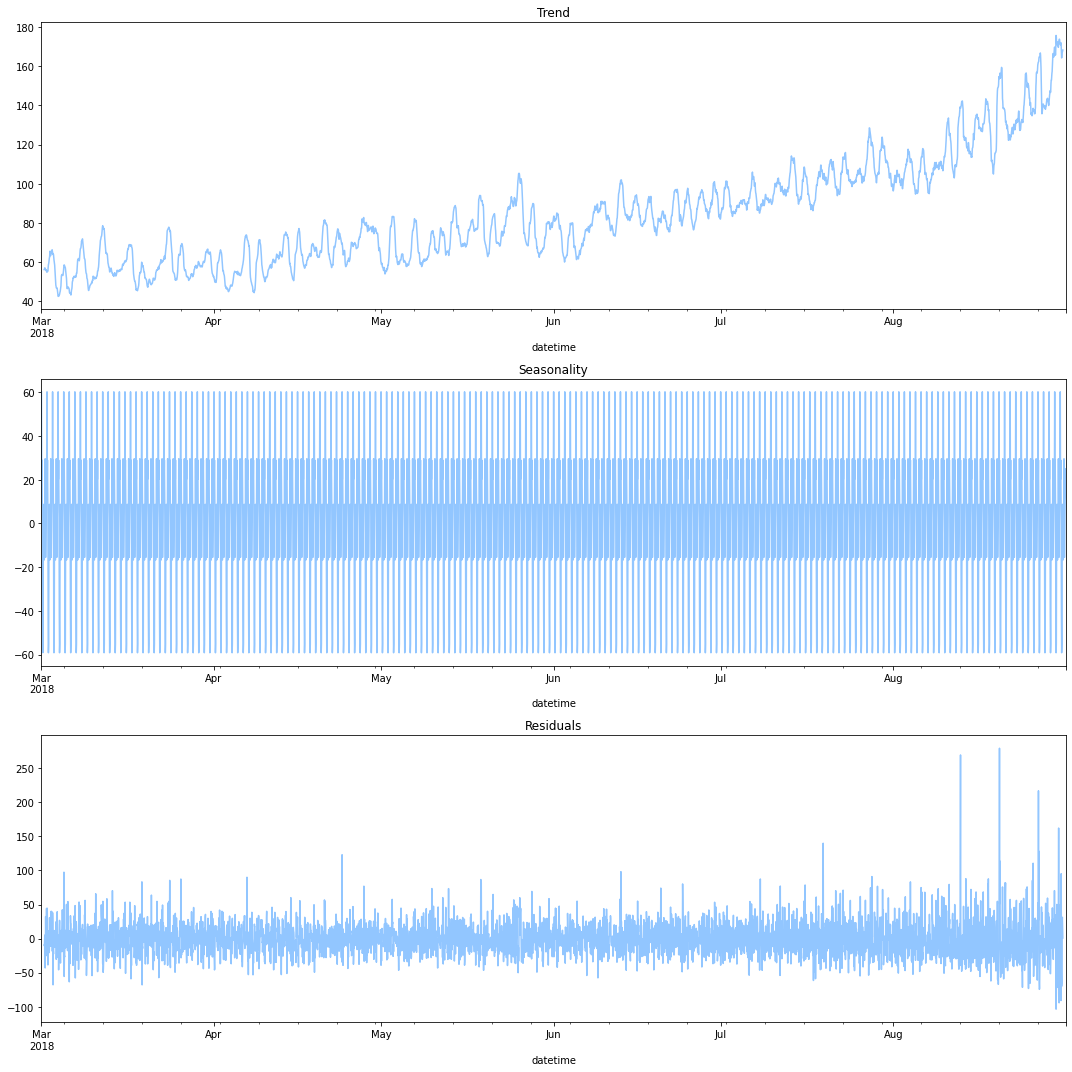

In [15]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Let's take a closer look.

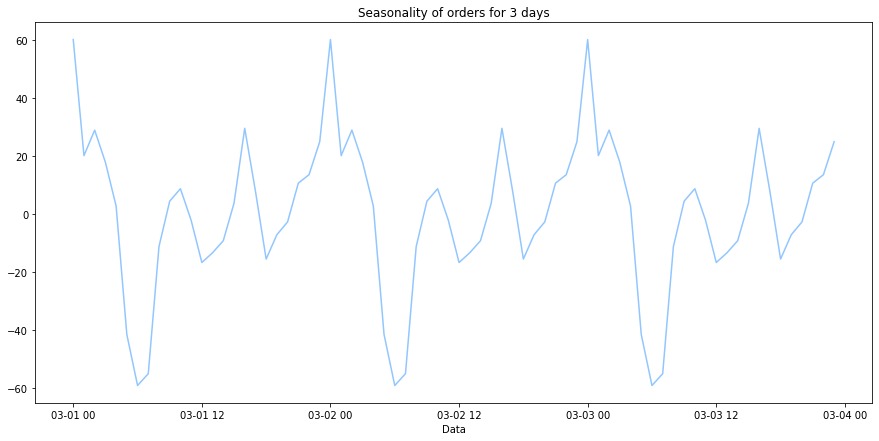

In [16]:
plt.figure(figsize=(15,7))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-3'])
plt.title('Seasonality of orders for 3 days')
plt.xlabel('Data')
plt.show()

Conclusion:

Based on the trend - the number of orders gradually increases. The business is developing. Seasonality - minimum orders at 6 am and gradually increasing at the end of the day.

Let's find the rolling standard deviation.

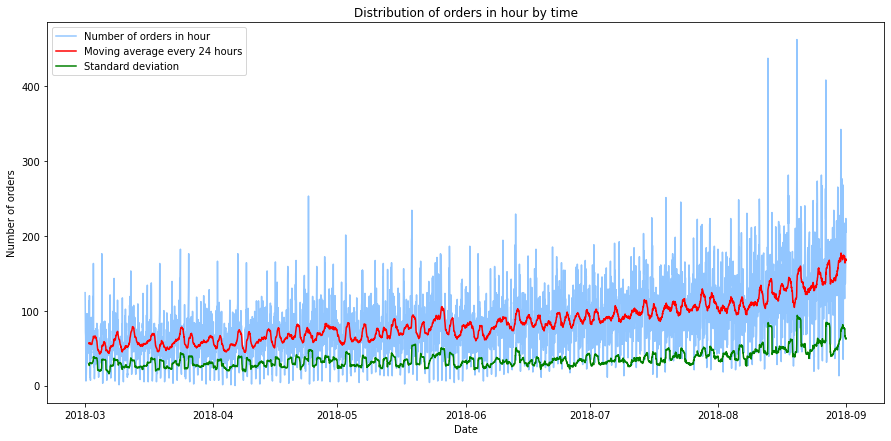

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(data)

plt.plot(data.rolling(24).mean(), 
         color='red')

plt.plot(data.rolling(24).std(), 
         color='green')

plt.title('Distribution of orders in hour by time')
plt.legend(['Number of orders in hour', 
            'Moving average every 24 hours', 
            'Standard deviation'])
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.show()

The series is stationary from 2018-03 to 2018-08. Then the series starts to change and becomes non-stationary. This may or may not affect the model.

Additionally, we will check the stationarity of the series with the Dickey-Fuller test.

In [18]:
ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('If the value with index 1 is less than the P-Value specified by us (usually 0.05), then the series is stationary.')
if st_test[1] < 0.05:
    print('Our series is stationary')
else:
    print('Our series is non-stationary')

If the value with index 1 is less than the P-Value specified by us (usually 0.05), then the series is stationary.
Our series is stationary


To make the series stationary, we will find the differences of its values.

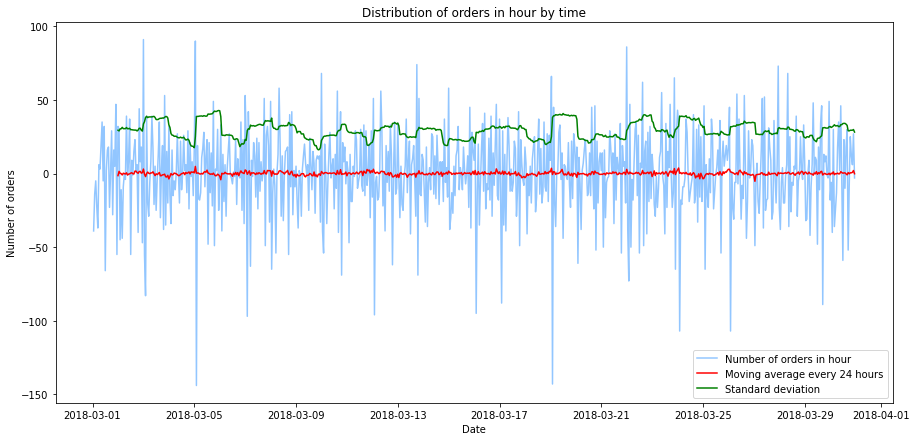

In [19]:
shifted_data = data - data.shift()

plt.figure(figsize=(15, 7))
plt.plot(shifted_data['2018-03-01':'2018-03-30'])

plt.plot(shifted_data['2018-03-01':'2018-03-30'].rolling(24).mean(), 
         color='red')

plt.plot(shifted_data['2018-03-01':'2018-03-30'].rolling(24).std(), 
         color='green')

plt.title('Distribution of orders in hour by time')
plt.legend(['Number of orders in hour', 
            'Moving average every 24 hours', 
            'Standard deviation'])
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.show()

As seen from the obtained graph, the series has become stationary, that is, if it is not possible to get the necessary quality metrics, one can use the difference of the time series.

## 3. Training models.

Let's prepare the data. 

We will write a function to create features 

Let's analyze each type of feature: 

* Calendar features - in many data, trends and seasonality are linked to a specific date. 

* Lagging values - previous values of the time series will indicate whether the function x(t) will increase or decrease. 

* Moving average - the moving average as a feature sets the overall trend of the time series. 

Since we have an increase in the number of orders throughout the day - let's take the maximum lagging value - 24 hours, and the moving average for 6 hours, since it is observed that every 6 hours the number of orders both increases and decreases.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Let's create new features and split into samples.

In [21]:
make_features(data, 1, 24)

train, test = train_test_split(data, 
                               shuffle=False, 
                               test_size=0.1)

train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Let's create a table for further model analysis.

In [22]:
analisys = pd.DataFrame({'model':[], 
                         'RMSE_model':[], 
                         'RMSE_on_train':[]})

all_models = []

The data is prepared, let's explore the models.

In [23]:
def train_model(model, parameters):
    
    best_rmse = 1000
    best_splits = 0
    best_model = 0
    
    start = time()
    for split in range(6, 25, 2):
        tscv = TimeSeriesSplit(n_splits=split)

        model_random = GridSearchCV(estimator=model,
                                    param_grid=parameters,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    cv=tscv, 
                                    verbose=1)
        
        model_random.fit(train_features, train_target)
        rmse = model_random.best_score_ * -1 ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_splits = split
            best_model = model_random

    print('GridSearchCV time in %.2f secondt' %(time() - start))
    print('Best splits:', best_splits)
    
    model_random = best_model
    
    rmse = model_random.best_score_ * -1 ** 0.5
    rmse_on_train = mean_squared_error(train_target, 
                                       model_random.predict(train_features), 
                                       squared=False)
    
    print('Best params:', model_random.best_params_)
    print('RMSE learned model:', round(rmse, 2))
    print('RMSE on the train sampleе:', round(rmse_on_train, 2))
    
    predicted = pd.DataFrame(model_random.predict(train_features), 
                             index=train_features.index)
    
    plt.figure(figsize=(15,7))

    plt.plot(train_target[:'2018-03-07'], 
             color='black', 
             alpha=0.7)
    
    plt.plot(predicted[:'2018-03-07'], 
             color='red', 
             alpha=0.7)
    
    plt.title('Comparing predictions on the model train for the first 7 days')
    plt.ylabel('Number of orders')
    plt.xlabel('Date')
    plt.legend(['Real', 'Predicted'])
    plt.show()
       
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

The model DecisionTreeRegressor

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Fitting 8 folds for each of 9 candidates, totalling 72 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 12 folds for each of 9 candidates, totalling 108 fits
Fitting 14 folds for each of 9 candidates, totalling 126 fits
Fitting 16 folds for each of 9 candidates, totalling 144 fits
Fitting 18 folds for each of 9 candidates, totalling 162 fits
Fitting 20 folds for each of 9 candidates, totalling 180 fits
Fitting 22 folds for each of 9 candidates, totalling 198 fits
Fitting 24 folds for each of 9 candidates, totalling 216 fits
GridSearchCV time in 22.60 secondt
Best splits: 20
Best params: {'max_depth': 7}
RMSE learned model: 19.74
RMSE on the train sampleе: 22.66


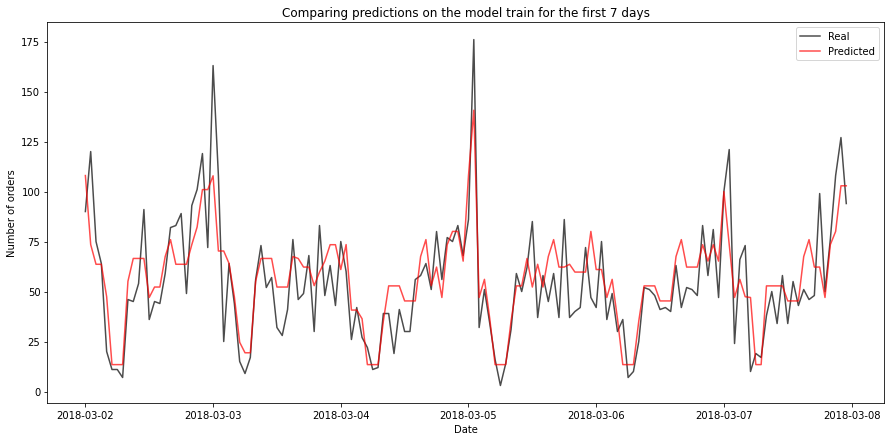

In [24]:
ran_grid_tree = {"max_depth": list(range(3, 12))}

dtr = DecisionTreeRegressor()

dtr_random = train_model(dtr, ran_grid_tree)

The model RandomForestRegressor

Fitting 6 folds for each of 21 candidates, totalling 126 fits
Fitting 8 folds for each of 21 candidates, totalling 168 fits
Fitting 10 folds for each of 21 candidates, totalling 210 fits
Fitting 12 folds for each of 21 candidates, totalling 252 fits
Fitting 14 folds for each of 21 candidates, totalling 294 fits
Fitting 16 folds for each of 21 candidates, totalling 336 fits
Fitting 18 folds for each of 21 candidates, totalling 378 fits
Fitting 20 folds for each of 21 candidates, totalling 420 fits
Fitting 22 folds for each of 21 candidates, totalling 462 fits
Fitting 24 folds for each of 21 candidates, totalling 504 fits
GridSearchCV time in 1050.65 secondt
Best splits: 22
Best params: {'max_depth': 8, 'n_estimators': 200}
RMSE learned model: 17.81
RMSE on the train sampleе: 19.58


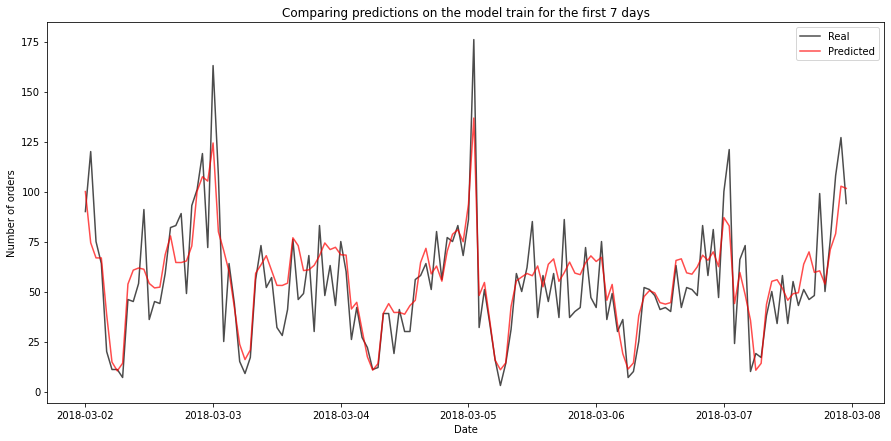

In [25]:
ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random = train_model(rfr, ran_grid_forest)

The model LGBMRegressor

Fitting 6 folds for each of 15 candidates, totalling 90 fits
Fitting 8 folds for each of 15 candidates, totalling 120 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 12 folds for each of 15 candidates, totalling 180 fits
Fitting 14 folds for each of 15 candidates, totalling 210 fits
Fitting 16 folds for each of 15 candidates, totalling 240 fits
Fitting 18 folds for each of 15 candidates, totalling 270 fits
Fitting 20 folds for each of 15 candidates, totalling 300 fits
Fitting 22 folds for each of 15 candidates, totalling 330 fits
Fitting 24 folds for each of 15 candidates, totalling 360 fits
GridSearchCV time in 137.55 secondt
Best splits: 24
Best params: {'learning_rate': 0.1, 'max_depth': 10}
RMSE learned model: 17.28
RMSE on the train sampleе: 17.36


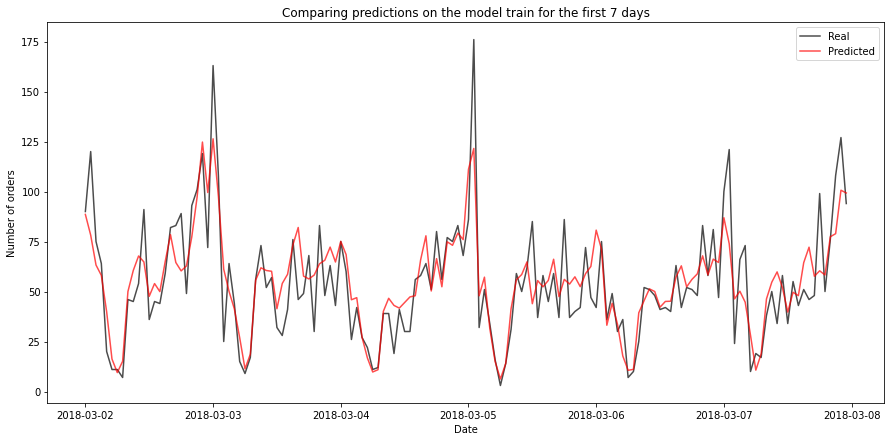

In [26]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random = train_model(gbm, rand_lgbm_param)

The model XGBRegressor

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Fitting 14 folds for each of 24 candidates, totalling 336 fits
Fitting 16 folds for each of 24 candidates, totalling 384 fits
Fitting 18 folds for each of 24 candidates, totalling 432 fits
Fitting 20 folds for each of 24 candidates, totalling 480 fits
Fitting 22 folds for each of 24 candidates, totalling 528 fits
Fitting 24 folds for each of 24 candidates, totalling 576 fits
GridSearchCV time in 402.22 secondt
Best splits: 22
Best params: {'learning_rate': 0.1, 'max_depth': 5}
RMSE learned model: 17.59
RMSE on the train sampleе: 17.58


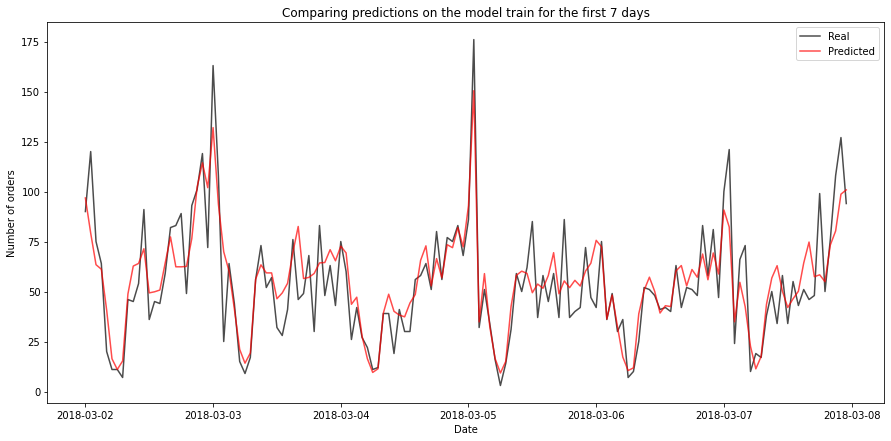

In [27]:
rand_xgb_param = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True,
                      verbosity=0)

xb_random = train_model(xb, rand_xgb_param)

The model CatBoostRegressor

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 12 folds for each of 10 candidates, totalling 120 fits
Fitting 14 folds for each of 10 candidates, totalling 140 fits
Fitting 16 folds for each of 10 candidates, totalling 160 fits
Fitting 18 folds for each of 10 candidates, totalling 180 fits
Fitting 20 folds for each of 10 candidates, totalling 200 fits
Fitting 22 folds for each of 10 candidates, totalling 220 fits
Fitting 24 folds for each of 10 candidates, totalling 240 fits
GridSearchCV time in 1009.72 secondt
Best splits: 24
Best params: {'learning_rate': 0.1, 'max_depth': 3}
RMSE learned model: 17.55
RMSE on the train sampleе: 18.16


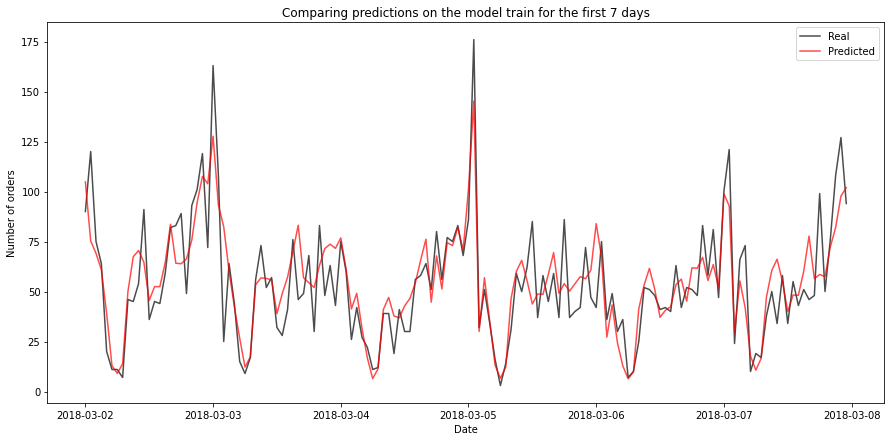

In [28]:
rand_cat_param = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False)  

cat_random = train_model(cat, rand_cat_param)

Let's look at the results.

In [29]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})

analisys = pd.concat([analisys, all_names], 
                     axis=1, 
                     join='inner')

display(analisys)

,model,RMSE_model,RMSE_on_train,names
0,DecisionTreeRegressor(),19.74,22.66,DecisionTree
1,RandomForestRegressor(n_jobs=-1),17.81,19.58,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",17.28,17.36,LightGBM
3,"XGBRegressor(base_score=None, booster='gbtree'...",17.59,17.58,XGBoost
4,<catboost.core.CatBoostRegressor object at 0x7...,17.55,18.16,CatBoost


Conclusion: 

Based on the results obtained, we see that the best performance was on the random model - LightGBM with parameters max_depth: 10 and learning_rate: 0.1 with the number of samples for training TimeSeriesSplit - 24, so for the test sample we will use LightGBM.

## 4. Testing models.

Let's consider the metric of the previously trained model on the test sample.

In [30]:
predicted = gbm_random.predict(test_features)
rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
print('The RMSE on the test sample when using RandomizedSearchCV:', round(rmse_on_test, 2))

The RMSE on the test sample when using RandomizedSearchCV: 43.51


The necessary metric was obtained and it does not exceed the limit values according to the condition, this data preprocessing and the current LightGBM model can be used in the future.

Let's look at the graphs comparing the predictions and the actual values.

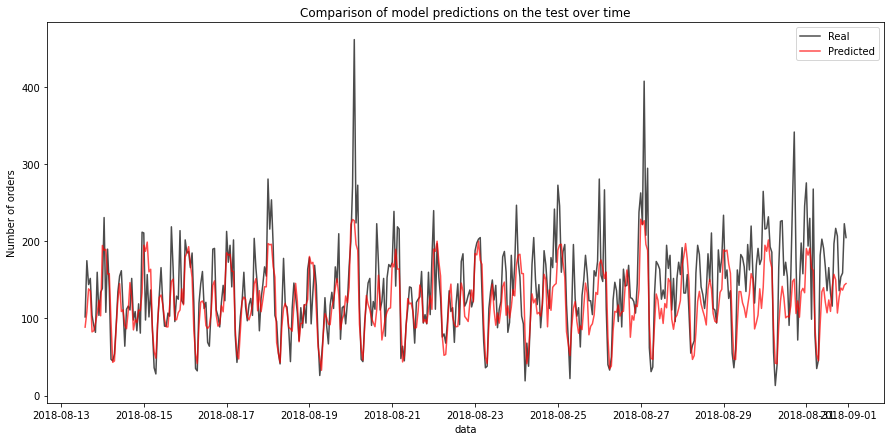

In [31]:
predicted = pd.DataFrame(predicted, index=test_features.index)

plt.figure(figsize=(15,7))
plt.plot(test_target, 
         color='black', 
         alpha=0.7)

plt.plot(predicted, 
         color='red', 
         alpha=0.7)

plt.title('Comparison of model predictions on the test over time')
plt.ylabel('Number of orders')
plt.xlabel('data')
plt.legend(['Real', 'Predicted'])
plt.show()

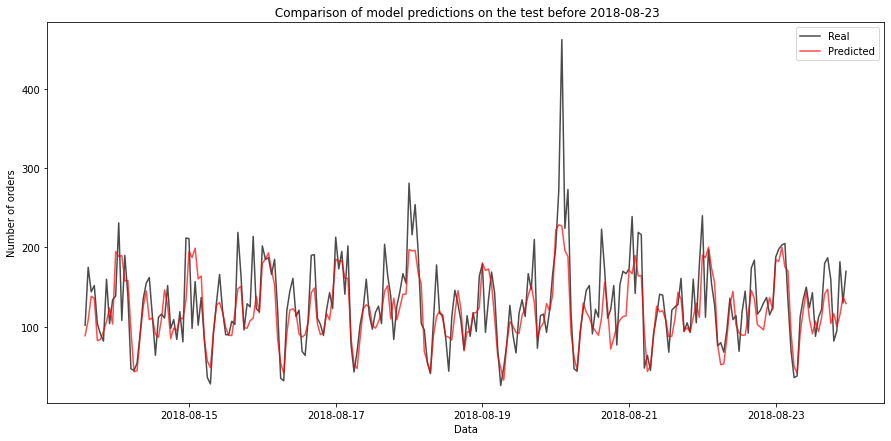

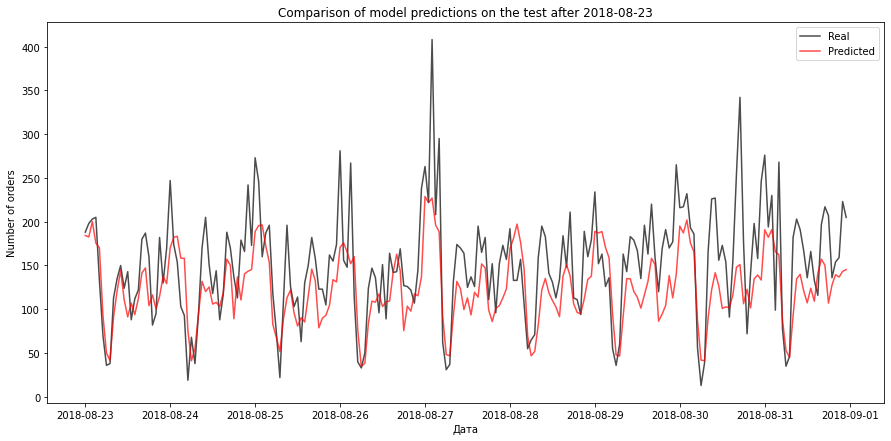

In [32]:
plt.figure(figsize=(15,7))
plt.plot(test_target[:'2018-08-23'], 
         color='black', 
         alpha=0.7)

plt.plot(predicted[:'2018-08-23'], 
         color='red', 
         alpha=0.7)

plt.title(' Comparison of model predictions on the test before 2018-08-23')
plt.ylabel('Number of orders')
plt.xlabel('Data')
plt.legend(['Real', 'Predicted'])
plt.show()

plt.figure(figsize=(15,7))
plt.plot(test_target['2018-08-23':], 
         color='black', 
         alpha=0.7)

plt.plot(predicted['2018-08-23':], 
         color='red', 
         alpha=0.7)

plt.title('Comparison of model predictions on the test after 2018-08-23')
plt.ylabel('Number of orders')
plt.xlabel('Дата')
plt.legend(['Real', 'Predicted'])
plt.show()

## 5. Overall conclusion:

* A dataset of 26496 rows was received for work. 
* No missing values were present. 
* The data was organized. 
* Hourly resampling was performed. 
* According to the trend, it is seen that the number of orders is increasing, which is a good indicator - the business is not standing still. 
* The data was prepared and models were trained. 
* On the training sample, the best result was shown by the LightGBM model, which can be confidently recommended to the customer for forecasting orders, and the model on the test sample showed the RMSE metric result of 43.51, which in turn is below the threshold value of 48. 
* The model shows insignificant deviations in forecasting only in peak values, which can be eliminated by more precise hyperparameter selection and increasing the volume of samples for both training and testing.